In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import networkx as nx
import subprocess
import itertools as it
from ast import literal_eval
import time 

In [2]:
def safe_literal_eval(val):
    try:
        if type(val) is dict:
            return val
        
        return literal_eval(val)
    except Exception:
        return None


In [3]:
import pandas as pd

df = pd.read_csv("../data/snapshots/snapshot_22688136.csv.gz")
df['other'] = df['other'].apply(safe_literal_eval)
df.head()

,createdAtBlockNumber,id,liquidity,token0Price,token1Price,totalValueLockedUSD,other,token0_decimals,token0_id,token0_name,token0_symbol,token1_decimals,token1_id,token1_name,token1_symbol,version,block_number
0,22642921,0xd0bdf5e0da79d3f047a741fae43f0de12dc07fcdf924...,10375352384363653388,0.009854,101.482245,18.420975,"{'feeTier': '10000', 'sqrtPrice': '79813180273...",18,0x514910771af9ca656af840dff83e8264ecf986ca,ChainLink Token,LINK,18,0xf94e7d0710709388bce3161c32b4eea56d3f91cc,Destra Network,DSync,v4,22688136
1,21880902,0xd185908c3b4f76d150a59b35be638daaff269eb66ac1...,6639386180484986,1.024226,0.976347,18.112682,"{'feeTier': '100', 'sqrtPrice': '7828558298452...",18,0x0000000000000000000000000000000000000000,Ethereum,ETH,18,0x0bfda9a1914dd56313da138143e871c2b7a01e39,STARFORCEONE GOLD,STFMG,v4,22688136
2,22161234,0x470571da0067d12e63b3a32eb1a4b220704e637c3e7c...,2291597475,1.058882,0.944392,17.790441,"{'feeTier': '10000', 'sqrtPrice': '76993790429...",8,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,18,0x2f913c820ed3beb3a67391a6eff64e70c4b20b19,Merlin BTC,M-BTC,v4,22688136
3,22161525,0xd720d4a7aa64f1e150418a5dffde50dc724cb84575a8...,2284397483,1.061188,0.942340,17.752730,"{'feeTier': '100', 'sqrtPrice': '7691009414817...",8,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,18,0x2f913c820ed3beb3a67391a6eff64e70c4b20b19,Merlin BTC,M-BTC,v4,22688136
4,22263523,0xbc1537b776704384fcffb2514aa338fad53dcceff1be...,1795079231028376446,0.000031,32255.144927,17.626592,"{'feeTier': '500', 'sqrtPrice': '1422915409270...",18,0x0000000000000000000000000000000000000000,Ethereum,ETH,18,0x7de47cd8ea2feef2d1b1b720c3141601b2a5f404,Copein,COPEIN,v4,22688136


In [4]:
# Only keep v3 and v4 versions
df = df[df.version.isin(['v3', 'v4'])]

In [5]:
MIN_TICK = -887272
MAX_TICK = 887272

In [6]:
def tick_to_sqrtPriceX96(tick):
    return int(1.0001 ** (tick / 2) * (2 ** 96))

sqrtPriceLowerX96 = tick_to_sqrtPriceX96(MIN_TICK)
sqrtPriceUpperX96 = tick_to_sqrtPriceX96(MAX_TICK)

def get_reserves(liquidity, sqrtPriceX96, sqrtPriceLowerX96, sqrtPriceUpperX96):
    if sqrtPriceX96 <= sqrtPriceLowerX96:
        amount0 = liquidity * (sqrtPriceUpperX96 - sqrtPriceLowerX96) // (sqrtPriceLowerX96 * sqrtPriceUpperX96)
        amount1 = 0
    elif sqrtPriceX96 < sqrtPriceUpperX96:
        amount0 = liquidity * (sqrtPriceUpperX96 - sqrtPriceX96) // (sqrtPriceX96 * sqrtPriceUpperX96)
        amount1 = liquidity * (sqrtPriceX96 - sqrtPriceLowerX96) // (2 ** 96)
    else:
        amount0 = 0
        amount1 = liquidity * (sqrtPriceUpperX96 - sqrtPriceLowerX96) // (2 ** 96)
    return amount0, amount1

def compute_reserves(row):
    try:
        tick = int(row['other']['tick'])
        sqrtPriceX96 = int(row['other']['sqrtPrice'])
        liquidity = int(row['liquidity'])
        reserve0, reserve1 = get_reserves(liquidity, sqrtPriceX96, sqrtPriceLowerX96, sqrtPriceUpperX96)
        return pd.Series({'token0_reserve': reserve0, 'token1_reserve': reserve1})
    except Exception:
        return pd.Series({'token0_reserve': None, 'token1_reserve': None})

df[['token0_reserve', 'token1_reserve']] = df.apply(compute_reserves, axis=1)


In [7]:
len(df[(df.token0_reserve == 0) | (df.token1_reserve == 0)]), len(df)

(8598, 9000)

In [20]:
top_token_counts = 1000
    
if top_token_counts is not None:
    # Sum totalValueLockedUSD for token0_id and token1_id separately
    tvl_token0 = df[['totalValueLockedUSD', 'token0_id']].groupby('token0_id').sum()
    tvl_token1 = df[['totalValueLockedUSD', 'token1_id']].groupby('token1_id').sum()

    # Rename columns for merging
    tvl_token0 = tvl_token0.rename(columns={'totalValueLockedUSD': 'tvl_token0'})
    tvl_token1 = tvl_token1.rename(columns={'totalValueLockedUSD': 'tvl_token1'})

    # Combine both by index (token id), fill NaN with 0, and sum to get total TVL per token id
    tvl_combined = tvl_token0.join(tvl_token1, how='outer').fillna(0)
    # Ensure columns are numeric before addition
    tvl_combined['tvl_token0'] = pd.to_numeric(tvl_combined['tvl_token0'], errors='coerce').fillna(0)
    tvl_combined['tvl_token1'] = pd.to_numeric(tvl_combined['tvl_token1'], errors='coerce').fillna(0)
    tvl_combined['totalValueLockedUSD'] = tvl_combined['tvl_token0'] + tvl_combined['tvl_token1']

    # Reset index to have token id as a column
    tvl_combined = tvl_combined[['totalValueLockedUSD']]
    tvl_combined = tvl_combined.reset_index().rename(columns={'index': 'token_id'})
    
    # Map token_id to token_symbol using original df
    token0_map = df[['token0_id', 'token0_symbol']].drop_duplicates().set_index('token0_id')['token0_symbol']
    token1_map = df[['token1_id', 'token1_symbol']].drop_duplicates().set_index('token1_id')['token1_symbol']

    # Combine both maps, prioritizing token0_map if duplicates exist
    token_symbol_map = token0_map.combine_first(token1_map)

    # Ensure token_symbol_map has unique indices
    token_symbol_map = token_symbol_map[~token_symbol_map.index.duplicated(keep='first')]

    # Add token_symbol column to tvl_combined
    tvl_combined['token_symbol'] = tvl_combined['token_id'].map(token_symbol_map)
    
    tvl_combined = tvl_combined.sort_values(by='totalValueLockedUSD', ascending=False)
    top_token_id_list = tvl_combined['token_id'].head(top_token_counts).tolist()
    
    df = df[df['token0_id'].isin(top_token_id_list) & df['token1_id'].isin(top_token_id_list)]
    # Filter df to only include top tokens        

tvl_combined.head(20)

,token_id,totalValueLockedUSD,token_symbol
7,0x160de4468586b6b2f8a92feb0c260fc6cfc743b1,1.111599e+12,ease.org
92,0xea5edef1c6ed1be1bcba4617a1c5a994e9018a43,1.110167e+12,ez-cvxsteCRV
81,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,2.577711e+09,WETH
65,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1.443633e+09,USDC
93,0xea5edef1fcf717327440646e7302ca058dde844f,1.432077e+09,ez-yvCurve-IronBank
13,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,9.447299e+08,WBTC
90,0xdac17f958d2ee523a2206206994597c13d831ec7,6.295843e+08,USDT
0,0x0000000000000000000000000000000000000000,2.191075e+08,ETH
41,0x6b175474e89094c44da98b954eedeac495271d0f,1.692130e+08,DAI
40,0x6982508145454ce325ddbe47a25d4ec3d2311933,1.262596e+08,PEPE


In [21]:
# df = df[(df.token0_id=="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48")&(df.token1_id=="0xdac17f958d2ee523a2206206994597c13d831ec7")]
# len(df)

In [22]:
def create_graph(df, apply_fee=False, remove_low_degree_nodes=False, remove_multi_edges=False, delta_fees=None, fake_fee=0.0):
    # Create a graph
    if remove_multi_edges:
        G = nx.DiGraph()
    else:
        G = nx.MultiDiGraph()
        
    df['other'] = df['other'].apply(safe_literal_eval)
    df['token0Price'] = pd.to_numeric(df['token0Price'], errors='coerce')
    df['token1Price'] = pd.to_numeric(df['token1Price'], errors='coerce')
    df = df.dropna(subset=['other', 'token0Price', 'token1Price'])

    # Check if 'feeTier' column exists, if not, create it
    if 'feeTier' not in df.columns:
        df['feeTier'] = df.apply(
            lambda row: int(row['other'].get('feeTier', 0)) if row['version'] in ['v3', 'v4'] 
            else 3000 if row['version'] == 'v2' 
            else None, 
            axis=1
        )
        df['feeTier'] = df['feeTier'].apply(float)
    
    if apply_fee:
        df['token0Price'] = df['token0Price'] * (1 - df['feeTier'] / 1e6)
        df['token1Price'] = df['token1Price'] * (1 - df['feeTier'] / 1e6)

    if fake_fee > 0.0:
        df['token0Price'] = df['token0Price'] * (1 - fake_fee)
        df['token1Price'] = df['token1Price'] * (1 - fake_fee)

    for _, row in df.iterrows():
        # Only add edge if reserves are sufficient
        token0_reserve = row.get('token0_reserve', None)
        token1_reserve = row.get('token1_reserve', None)
        # Check for missing or non-numeric reserves
        try:
            token0_reserve = float(token0_reserve)
            token1_reserve = float(token1_reserve)
        except Exception:
            continue

        # Add nodes
        G.add_node(row['token0_id'], token_symbol=row['token0_symbol'])
        G.add_node(row['token1_id'], token_symbol=row['token1_symbol'])

        # token1 -> token0 (swap token1 for token0, must have token0_reserve)
        if token0_reserve > 0:
            # use large positive weight if undefined
            weight_0 = math.log(row['token0Price']) * -1 if float(row['token0Price']) > 0 else 1e10
            if remove_multi_edges:
                if G.has_edge(row['token1_id'], row['token0_id']):
                    existing_weight = G[row['token1_id']][row['token0_id']]['weight']
                    if weight_0 < existing_weight:
                        G[row['token1_id']][row['token0_id']]['weight'] = weight_0
                else:
                    G.add_edge(row['token1_id'], row['token0_id'], weight=weight_0, version=row.get('version', None))
            else:
                G.add_edge(row['token1_id'], row['token0_id'], weight=weight_0, version=row.get('version', None))

        # token0 -> token1 (swap token0 for token1, must have token1_reserve)
        if token1_reserve > 0:
            weight_1 = math.log(row['token1Price']) * -1 if float(row['token1Price']) > 0 else 1e10
            if remove_multi_edges:
                if G.has_edge(row['token0_id'], row['token1_id']):
                    existing_weight = G[row['token0_id']][row['token1_id']]['weight']
                    if weight_1 < existing_weight:
                        G[row['token0_id']][row['token1_id']]['weight'] = weight_1
                else:
                    G.add_edge(row['token0_id'], row['token1_id'], weight=weight_1, version=row.get('version', None))
            else:
                G.add_edge(row['token0_id'], row['token1_id'], weight=weight_1, version=row.get('version', None))
    
    # Remove nodes with degree less than 2 if the flag is set
    if remove_low_degree_nodes:
        while True:
            nodes_to_remove = [node for node in G.nodes() if G.in_degree(node) == 1 and G.out_degree(node) == 1]
            if len(nodes_to_remove) == 0:
                break
            G.remove_nodes_from(nodes_to_remove)


    # clip edges with weight too small 


    # # todo: revert this patch
    # for u, v, data in list(G.edges(data=True)):
    #     if 'weight' in data and data['weight'] < -0.5:
    #         weight_before = data['weight']
    #         new_weight = 0 
    #         G[u][v]['weight'] = new_weight
    
    return G


In [23]:
G = create_graph(df, apply_fee=False, remove_low_degree_nodes=False, remove_multi_edges=True, fake_fee=0.9)

print(len(G.nodes), len(G.edges))

100 317


In [24]:
try:
    negative_cycle = nx.find_negative_cycle(G, source='0xdac17f958d2ee523a2206206994597c13d831ec7')
    G_sub = G.subgraph(negative_cycle)
    G_sub.nodes

except Exception as e:
    print(f"No negative cycle found: {e}")
    G_sub = None


In [25]:
# Prepare mapping from node id to token_symbol
def get_symbol(node):
    symbol = G_sub.nodes[node].get('token_symbol')
    if symbol is None:
        symbol = token_symbol_map.get(node, node)
    return symbol


if G_sub:
    edges_str = []
    for u, v, d in G_sub.edges(data=True):
        u_sym = get_symbol(u)
        v_sym = get_symbol(v)
        weight = d.get('weight', None)
        edges_str.append(f"({u_sym} -> {v_sym}, weight={weight:.4f})")

    print(" | ".join(edges_str))

(USDC -> DAI, weight=2.3026) | (DAI -> USDC, weight=-25.3284)


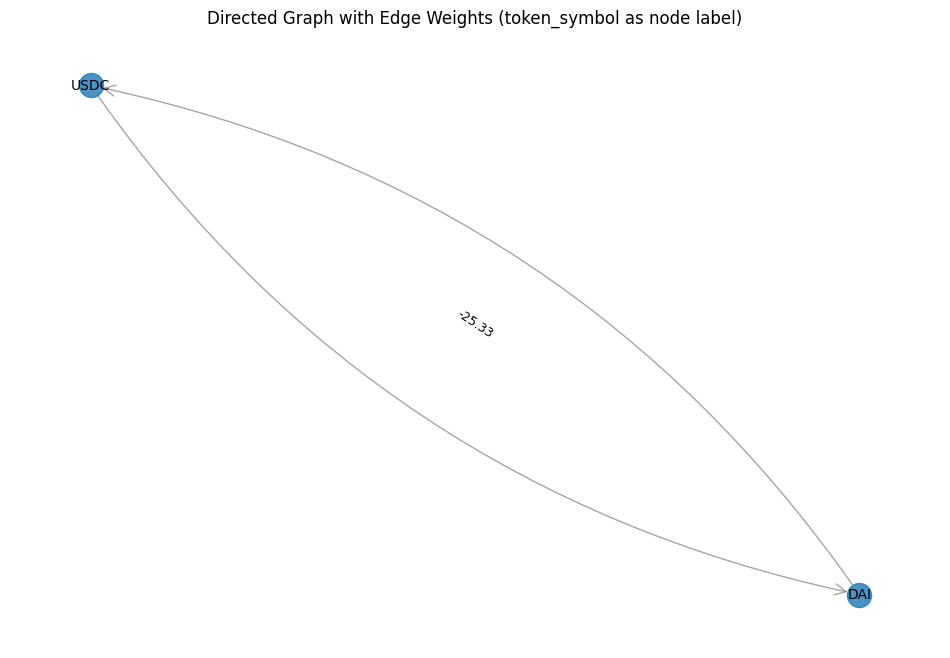

In [26]:
# Prepare mapping from node id to token_symbol
if G_sub:
    node_labels = {}
    for node in G_sub.nodes():
        symbol = G_sub.nodes[node].get('token_symbol')
        if symbol is None:
            symbol = token_symbol_map.get(node, node)
        node_labels[node] = symbol

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, seed=42)

    # Draw nodes with labels (token_symbol)
    nx.draw_networkx_nodes(G_sub, pos, node_size=300, alpha=0.8)
    nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=10)

    # Draw directed edges with arrows for each direction
    nx.draw_networkx_edges(G_sub, pos, arrowstyle='->', arrowsize=20, connectionstyle='arc3,rad=0.2', edge_color='gray', alpha=0.7)

    # Draw edge weights for all edges (both directions)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G_sub.edges(data=True)}
    nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5, verticalalignment='bottom')

    plt.title("Directed Graph with Edge Weights (token_symbol as node label)")
    plt.axis('off')
    plt.show()


In [27]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# force reloading of uniprice module

if 'uniprice' in sys.modules:
    del sys.modules['uniprice']
import uniprice


uniprice = uniprice.UniPrice()

In [35]:


time_accept = time.time()
ans = uniprice.accept_graph(G)
print(f"Time to accept graph: {time.time() - time_accept:.2f} seconds")

for v in ans['singular_vertices']:
    print(f"Singular vertex: {v} ({G.nodes[v].get('token_symbol', v)})")

Time to accept graph: 0.02 seconds


In [29]:
D, parents = uniprice.query_sssp("0x0000000000000000000000000000000000000000")

In [30]:
D

{'0x0000000000000000000000000000000000000000': 0.0,
 '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': -47.04787468309917,
 '0x45804880de22913dafe09f4980848ece6ecbaf78': 2.5132681157441565,
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 5.953312896235605,
 '0xd31a59c85ae9d8edefec411d448f90841571b89c': -242.9293237269812,
 '0xdac17f958d2ee523a2206206994597c13d831ec7': -67.55595264655935,
 '0x6982508145454ce325ddbe47a25d4ec3d2311933': -172.99811822672962,
 '0x6b175474e89094c44da98b954eedeac495271d0f': -60.84875790722649,
 '0x437cc33344a0b27a429f795ff6b469c72698b291': -5.555834095450373,
 '0x582d872a1b094fc48f5de31d3b73f2d9be47def1': -4.427866620389788,
 '0xfaba6f8e4a5e8ab82f62fe7c39859fa577269be3': -261.9884484215253,
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984': -3.703265112963663,
 '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0': -196.617718989029,
 '0x046eee2cc3188071c02bfc1745a6b17c656e3f3d': -8.590183179447212,
 '0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9': -0.007854533678393671,
 '0x80ac

In [31]:
parents

{}

In [32]:
# now use built-in function to find shortest paths in networkx

from_token = "0x0000000000000000000000000000000000000000"

print("--- Using NetworkX Bellman-Ford Algorithm ---")

try:
    # Use single_source_bellman_ford which is correct for graphs with negative weights.
    # It efficiently returns both the path lengths and the paths themselves.
    lengths, paths = nx.single_source_bellman_ford(G, from_token)

    # print paths with weights
    for token, path in paths.items():
        # The path is from from_token to the target 'token'
        path_str = " -> ".join(map(str, path))
        print(f"Path to {token}: {path_str}")

        # The length is already calculated for us by the function
        total_weight = lengths[token]
        
        print(f"NetworkX answer: {total_weight:.4f}")
        
        # Compare with your UniPrice result if available
        if token in D:
            print(f"UniPrice answer: {D[token]:.4f}")
        else:
            print(f"UniPrice answer: No path found for {token}")
            
        print(f"=======")

except nx.NetworkXUnbounded:
    print(f"Error: A negative cycle was detected in the graph reachable from {from_token}.")
    print("The shortest path is undefined.")

except nx.NodeNotFound:
    print(f"Error: The source node {from_token} was not found in the graph.")


--- Using NetworkX Bellman-Ford Algorithm ---
Error: A negative cycle was detected in the graph reachable from 0x0000000000000000000000000000000000000000.
The shortest path is undefined.
